In [201]:
import pandas as pd
import os
import sys

project_root = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(project_root)

from utils.cmod5n import cmod5n_forward, cmod5n_inverse
from utils.functions import *

import xarray as xr
from glob import glob

In [305]:
df1 = pd.read_parquet("../processed_data/wv1_complete.parquet")
df2 = pd.read_parquet("../processed_data/wv2_complete.parquet")

df1 = create_phi_bins_columns(df1, 'phi_nominal_median', 1)
df2 = create_phi_bins_columns(df2, 'phi_nominal_median', 1)

df1r = pd.read_parquet("../results_15_May/wv1_results_updated.parquet")
df2r = pd.read_parquet("../results_15_May/wv2_results_updated.parquet")

df1w = pd.read_parquet("../wv1_wind_results.parquet")
df2w = pd.read_parquet("../wv2_wind_results.parquet")

df1r["renamed_filename"] = df1r.sar_filepath.apply(lambda x: x.split("/")[-1])
df2r["renamed_filename"] = df2r.sar_filepath.apply(lambda x: x.split("/")[-1])

df1w["renamed_filename"] = df1w.sar_filepath.apply(lambda x: x.split("/")[-1])
df2w["renamed_filename"] = df2w.sar_filepath.apply(lambda x: x.split("/")[-1])

idxmax = df1w.k_values_wind.apply(lambda x: len(x)).argmax()
max_len = df1w.k_values_wind.apply(lambda x: len(x)).max()

df1r = pad_arrays_to_max_length(df1r, 'radial_psd', max_len)
df2r = pad_arrays_to_max_length(df2r, 'radial_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_wind_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_wind_psd', max_len)

df1w = pad_arrays_to_max_length(df1w, 'radial_residual_psd', max_len)
df2w = pad_arrays_to_max_length(df2w, 'radial_residual_psd', max_len)

In [306]:
k_values = get_k_values(df1r, "k_values")
k_values = k_values/20

In [307]:
# df1_rg, df1r_rg, df1w_rg = create_dfs_from_phi_interval('[-90, -89)', df1, df1r, df1w)
# df2_rg, df2r_rg, df2w_rg = create_dfs_from_phi_interval('[-90, -89)', df2, df2r, df2w)

In [308]:
# plot_avg_spectral_density(k_values, [df2w_rg, df1w_rg], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                           "Average Wind PSD", 
#                           x_range=(0.0001, 0.15), y_range=(0, 0.5e8), 
#                           use_log_scale=False, wavelength=True, bootstrap=True);

In [309]:
phi_mapping1 = df1r.set_index('renamed_filename')['phi_nominal']
phi_mapping2 = df2r.set_index('renamed_filename')['phi_nominal']

era5_wspd_mapping1 = df1r.set_index('renamed_filename')['era5_wspd']
era5_wspd_mapping2 = df2r.set_index('renamed_filename')['era5_wspd']

df1w['phi'] = df1w['renamed_filename'].map(phi_mapping1)
df2w['phi'] = df2w['renamed_filename'].map(phi_mapping2)

df1w['era5_wspd'] = df1w['renamed_filename'].map(era5_wspd_mapping1)
df2w['era5_wspd'] = df2w['renamed_filename'].map(era5_wspd_mapping2)

L_mapping1 = df1.set_index('renamed_filename')['L']
L_mapping2 = df2.set_index('renamed_filename')['L']

df1w['L'] = df1w['renamed_filename'].map(L_mapping1)
df2w['L'] = df2w['renamed_filename'].map(L_mapping2)

In [310]:
df1w['residual_wspd'] = df1w['era5_wspd'] - df1w['wind_field_median']
df2w['residual_wspd'] = df2w['era5_wspd'] - df2w['wind_field_median']

(-1000000.0, -1000.0)

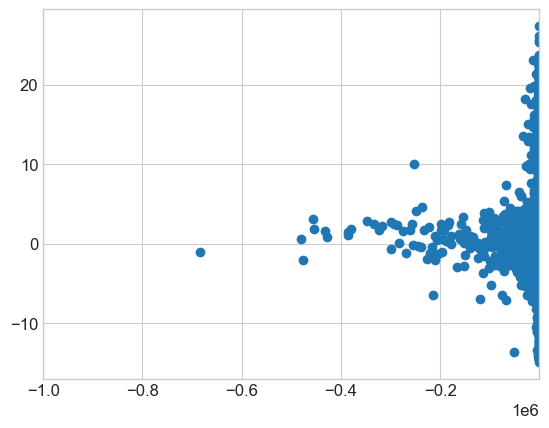

In [376]:
plt.scatter(df1w['L'], df1w['residual_wspd'])
plt.xlim(-1e6, -0.1e4)

(-1000000.0, -10000.0)

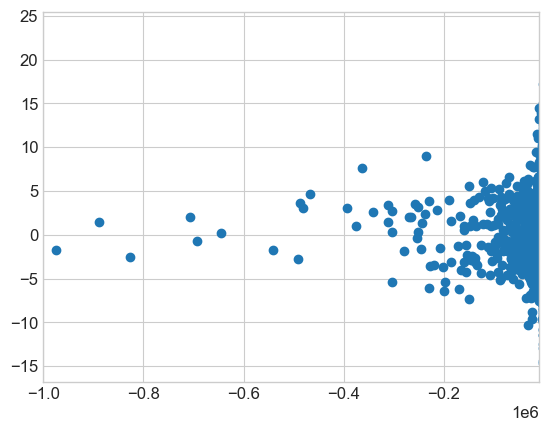

In [328]:
plt.scatter(df2w['L'], df2w['residual_wspd'])
plt.xlim(-1e6, -1e4)

In [377]:
df1w_L_filtered = df1w[(df1w.L > -1e8) & (df1w.L < -0.1e4)].copy()
df2w_L_filtered = df2w[(df2w.L > -1e8) & (df2w.L < -1e4)].copy()

In [378]:
sigma_sar_median_mapping1 = df1r.set_index('renamed_filename')['sigma_sar_median']
sigma_sar_median_mapping2 = df2r.set_index('renamed_filename')['sigma_sar_median']

sigma_cmod_median_mapping1 = df1r.set_index('renamed_filename')['sigma_cmod_median']
sigma_cmod_median_mapping2 = df2r.set_index('renamed_filename')['sigma_cmod_median']

df1w_L_filtered['sigma_cmod_median'] = df1w_L_filtered['renamed_filename'].map(sigma_cmod_median_mapping1)
df2w_L_filtered['sigma_cmod_median'] = df2w_L_filtered['renamed_filename'].map(sigma_cmod_median_mapping2)

df1w_L_filtered['sigma_sar_median'] = df1w_L_filtered['renamed_filename'].map(sigma_sar_median_mapping1)
df2w_L_filtered['sigma_sar_median'] = df2w_L_filtered['renamed_filename'].map(sigma_sar_median_mapping2)


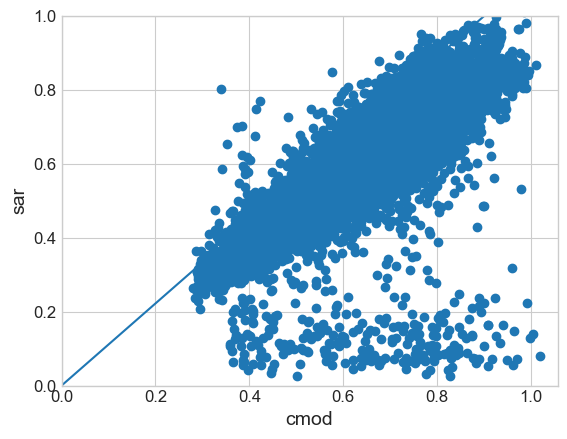

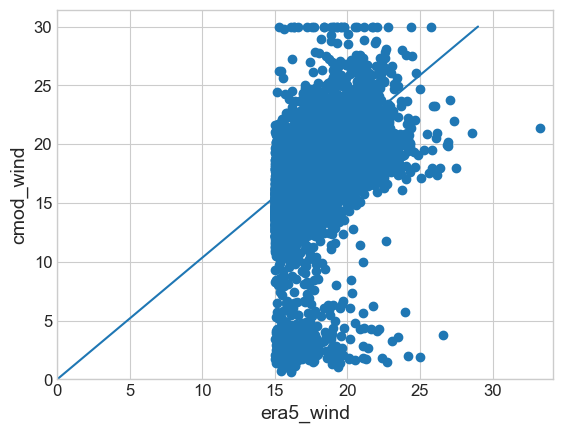

In [380]:
plt.scatter(df1w_L_filtered.sigma_cmod_median, df1w_L_filtered.sigma_sar_median)
plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel("cmod")
plt.ylabel("sar")

plt.ylim(0,1)

y_is_x_line = np.linspace(0, 10, 10)
plt.plot(y_is_x_line)
plt.show()

plt.scatter(df1w_L_filtered.era5_wspd, df1w_L_filtered.wind_field_median)
plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel("era5_wind")
plt.ylabel("cmod_wind")

y_is_x_line = np.linspace(0, 30, 30)
plt.plot(y_is_x_line)
plt.show()

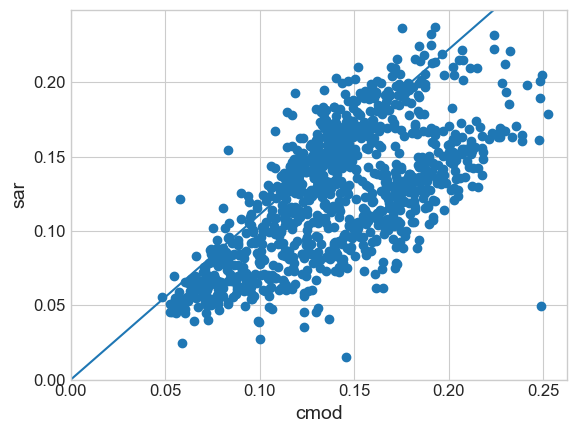

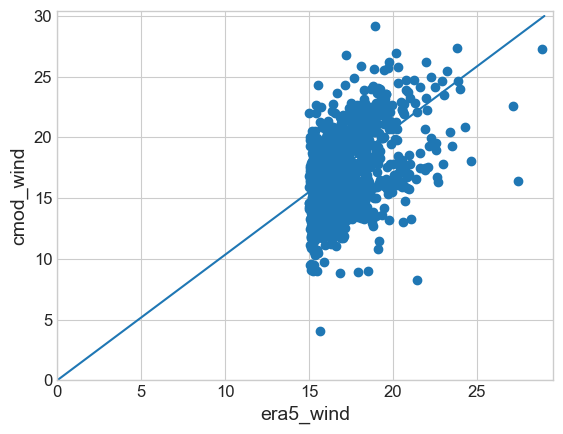

In [381]:
plt.scatter(df2w_L_filtered.sigma_cmod_median, df2w_L_filtered.sigma_sar_median)
plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel("cmod")
plt.ylabel("sar")

y_is_x_line = np.linspace(0, 10, 10)
plt.plot(y_is_x_line)
plt.show()

plt.scatter(df2w_L_filtered.era5_wspd, df2w_L_filtered.wind_field_median)
plt.xlim(0, None)
plt.ylim(0, None)

plt.xlabel("era5_wind")
plt.ylabel("cmod_wind")

y_is_x_line = np.linspace(0, 30, 30)
plt.plot(y_is_x_line)
plt.show()

In [382]:
df1w_L_filtered = create_phi_bins_columns(df1w_L_filtered, 'phi', 30)
df2w_L_filtered = create_phi_bins_columns(df2w_L_filtered, 'phi', 30)

In [383]:
df1w_L_filtered.columns

Index(['sar_filepath', 'radial_wind_psd', 'radial_residual_psd',
       'k_values_wind', 'b0', 'b1', 'b2', 'wind_field_median',
       'renamed_filename', 'radial_wind_psd_padded',
       'radial_residual_psd_padded', 'phi', 'era5_wspd', 'L', 'residual_wspd',
       'sigma_cmod_median', 'sigma_sar_median', 'phi_bins'],
      dtype='object')

In [384]:
df1w_L_filtered.groupby('phi_bins')['residual_wspd'].mean()

phi_bins
[-120, -90)     1.402547
[-150, -120)    1.818076
[-180, -150)    1.345785
[-30, 0)       -0.346627
[-60, -30)     -0.786875
[-90, -60)     -0.553100
[0, 30)        -0.151003
[120, 150)      1.173291
[150, 180)      1.263090
[30, 60)       -0.323297
[60, 90)       -0.073246
[90, 120)       1.012055
Name: residual_wspd, dtype: float64

In [385]:
df1w_L_filtered.groupby('phi_bins').count()

,sar_filepath,radial_wind_psd,radial_residual_psd,k_values_wind,b0,b1,b2,wind_field_median,renamed_filename,radial_wind_psd_padded,radial_residual_psd_padded,phi,era5_wspd,L,residual_wspd,sigma_cmod_median,sigma_sar_median
phi_bins,,,,,,,,,,,,,,,,,
"[-120, -90)",257,257,257,257,257,257,257,257,257,257,257,257,257,257,257,257,257
"[-150, -120)",405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405,405
"[-180, -150)",1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133,1133
"[-30, 0)",1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449,1449
"[-60, -30)",448,448,448,448,448,448,448,448,448,448,448,448,448,448,448,448,448
"[-90, -60)",259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259,259
"[0, 30)",2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382,2382
"[120, 150)",1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784,1784
"[150, 180)",2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173,2173


In [207]:
df1w = create_phi_bins_columns(df1w, 'phi', 30)
df2w = create_phi_bins_columns(df2w, 'phi', 30)

In [ ]:
df1w.columns

Index(['sar_filepath', 'radial_wind_psd', 'radial_residual_psd',
       'k_values_wind', 'b0', 'b1', 'b2', 'wind_field_median',
       'renamed_filename', 'radial_wind_psd_padded',
       'radial_residual_psd_padded', 'phi', 'phi_bins', 'mean_b2', 'era5_wspd',
       'L'],
      dtype='object')

In [208]:
df1w['mean_b2'] = df1w['b2'].apply(lambda x: get_mean(x))
df2w['mean_b2'] = df2w['b2'].apply(lambda x: get_mean(x))

In [209]:
df1_b2 = df1w[['mean_b2', 'phi_bins']].copy()
df2_b2 = df2w[['mean_b2', 'phi_bins']].copy()

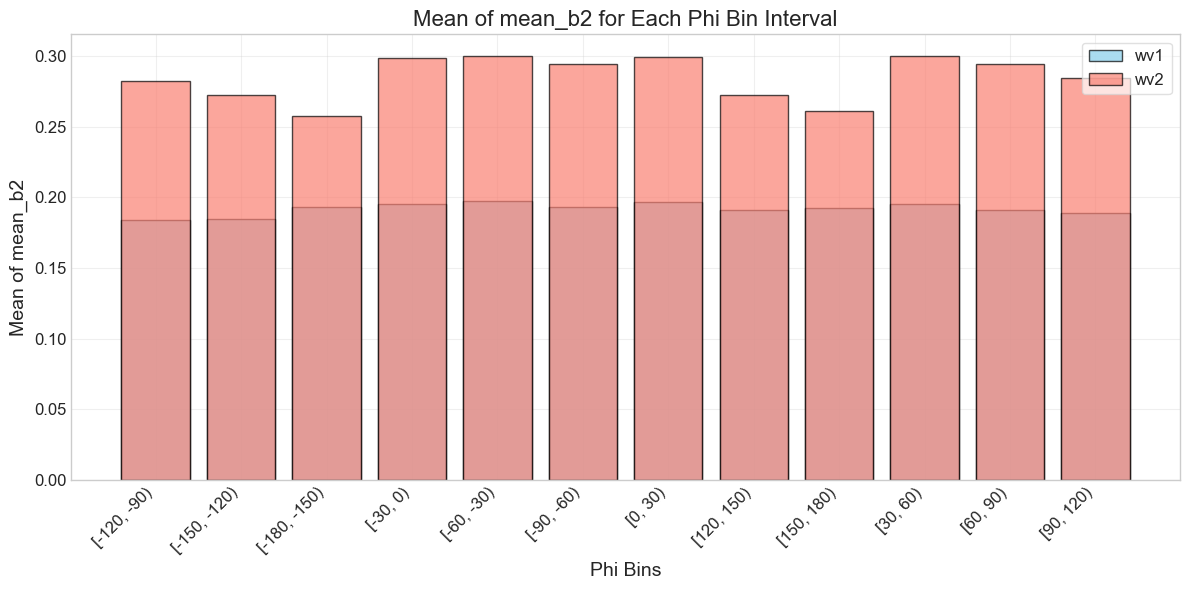

In [210]:
# Group by phi_bins and calculate the mean of mean_b2 for each bin
grouped_means1 = df1_b2.groupby('phi_bins')['mean_b2'].mean()
grouped_means2 = df2_b2.groupby('phi_bins')['mean_b2'].mean()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(grouped_means1)), grouped_means1.values, alpha=0.7, color='skyblue', edgecolor='black',
        label="wv1")
plt.bar(range(len(grouped_means2)), grouped_means2.values, alpha=0.7, color='salmon', edgecolor='black',
        label="wv2")
# Set x-axis labels to show the phi bin intervals
plt.xticks(range(len(grouped_means1)), grouped_means1.index, rotation=45, ha='right')
plt.xlabel('Phi Bins')
plt.ylabel('Mean of mean_b2')
plt.title('Mean of mean_b2 for Each Phi Bin Interval')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# # Print the results as well
# print("Mean of mean_b2 for each phi bin for WV1:")
# for bin_interval, mean_value in grouped_means1.items():
#     print(f"{bin_interval}: {mean_value:.6f}")

# print("\nMean of mean_b2 for each phi bin for WV2:")
# for bin_interval, mean_value in grouped_means2.items():
#     print(f"{bin_interval}: {mean_value:.6f}")


In [211]:
grouped_means_psd1 = df1w.groupby('phi_bins')['radial_wind_psd_padded'].mean()
grouped_means_psd2 = df2w.groupby('phi_bins')['radial_wind_psd_padded'].mean()

grouped_means_residual1 = df1w.groupby('phi_bins')['radial_residual_psd_padded'].mean()
grouped_means_residual2 = df2w.groupby('phi_bins')['radial_residual_psd_padded'].mean()

In [168]:
idxs_to_drop = df1w[df1w['radial_residual_psd_padded'].apply(lambda x: np.isnan(x).sum()) > 0].index
df1w = df1w.drop(idxs_to_drop)
idxs_to_drop = df2w[df2w['radial_residual_psd_padded'].apply(lambda x: np.isnan(x).sum()) > 0].index
df2w = df2w.drop(idxs_to_drop)

In [169]:
grouped_means_psd1 = df1w.groupby('phi_bins')['radial_wind_psd_padded'].mean()
grouped_means_psd2 = df2w.groupby('phi_bins')['radial_wind_psd_padded'].mean()

grouped_means_residual1 = df1w.groupby('phi_bins')['radial_residual_psd_padded'].mean()
grouped_means_residual2 = df2w.groupby('phi_bins')['radial_residual_psd_padded'].mean()

In [170]:
epsilon = 1e-10  # or any small number you prefer
psd_ratio = (grouped_means_psd1 + epsilon) / (grouped_means_psd2 + epsilon)

residual_psd_ratio = (grouped_means_residual1 + epsilon) / (grouped_means_residual2 + epsilon)


In [171]:
df1w['mean_b1'] = df1w['b1'].apply(lambda x: get_mean(x))
df2w['mean_b1'] = df2w['b1'].apply(lambda x: get_mean(x))

df1w['mean_b0'] = df1w['b0'].apply(lambda x: get_mean(x))
df2w['mean_b0'] = df2w['b0'].apply(lambda x: get_mean(x))

In [172]:
b0_mean_ratio = df1w.groupby('phi_bins')['mean_b0'].mean() / df2w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_ratio = df1w.groupby('phi_bins')['mean_b1'].mean() / df2w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_ratio = df1w.groupby('phi_bins')['mean_b2'].mean() / df2w.groupby('phi_bins')['mean_b2'].mean()


b0_correlations, wavelengths = analyze_b_parameter_vs_psd(b0_mean_ratio, psd_ratio, k_values, 'B0');
b1_correlations, wavelengths = analyze_b_parameter_vs_psd(b1_mean_ratio, psd_ratio, k_values, 'B1');
b2_correlations, wavelengths = analyze_b_parameter_vs_psd(b2_mean_ratio, psd_ratio, k_values, 'B2');


In [173]:
b0_mean_wv1 = df1w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv1 = df1w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv1 = df1w.groupby('phi_bins')['mean_b2'].mean()

b0_mean_wv2 = df2w.groupby('phi_bins')['mean_b0'].mean()
b1_mean_wv2 = df2w.groupby('phi_bins')['mean_b1'].mean()
b2_mean_wv2 = df2w.groupby('phi_bins')['mean_b2'].mean()


In [184]:
b0_corr, b0_lo, b0_hi, wavelengths = analyze_b_parameter_vs_psd_bootstrap(
    b0_mean_wv2, grouped_means_psd2, k_values, 'B0', n_boot=1000, plot=False)

b1_corr, b1_lo, b1_hi, wavelengths = analyze_b_parameter_vs_psd_bootstrap(
    b1_mean_wv2, grouped_means_psd2, k_values, 'B1', n_boot=1000, plot=False)

b2_corr, b2_lo, b2_hi, wavelengths = analyze_b_parameter_vs_psd_bootstrap(
    b2_mean_wv2, grouped_means_psd2, k_values, 'B2', n_boot=1000, plot=False)

In [195]:
def plot_b_coeff_correlations(
    wavelengths,
    b0_correlations, b0_ci_lower=None, b0_ci_upper=None,
    b1_correlations=None, b1_ci_lower=None, b1_ci_upper=None,
    b2_correlations=None, b2_ci_lower=None, b2_ci_upper=None,
    use_semilogx=True
):
    fig, ax = plt.subplots(figsize=(14, 9))
    plot_func = ax.semilogx if use_semilogx else ax.plot

    # Plot B0
    plot_func(wavelengths, b0_correlations, 'r-.', label='B0 wrt PSD_wind', linewidth=2.5)
    if b0_ci_lower is not None and b0_ci_upper is not None:
        ax.fill_between(wavelengths, b0_ci_lower, b0_ci_upper, color='red', alpha=0.2)

    # Plot B1
    if b1_correlations is not None:
        plot_func(wavelengths, b1_correlations, 'g-.', label='B1 wrt PSD_wind', linewidth=2.5)
        if b1_ci_lower is not None and b1_ci_upper is not None:
            ax.fill_between(wavelengths, b1_ci_lower, b1_ci_upper, color='green', alpha=0.2)

    # Plot B2
    if b2_correlations is not None:
        plot_func(wavelengths, b2_correlations, 'b-.', label='B2 wrt PSD_wind', linewidth=2.5)
        if b2_ci_lower is not None and b2_ci_upper is not None:
            ax.fill_between(wavelengths, b2_ci_lower, b2_ci_upper, color='blue', alpha=0.2)

    # Reference line
    ax.axhline(y=0, color='black', linestyle='--', alpha=0.5, label='No correlation')

    # Interpretation zones
    # ax.axhspan(0.5, 1.0, alpha=0.1, color='red', label='Strong positive correlation')
    # ax.axhspan(-1.0, -0.5, alpha=0.1, color='blue', label='Strong negative correlation')

    # Labels and title
    ax.set_xlabel('Wavelength [m]', fontsize=14)
    ax.set_ylabel('Correlation coefficient', fontsize=14)
    ax.set_xlim(200, 5000)
    # ax.set_xticks([200, 1000, 2000, 5000, 10000, 20000])
    N = 12
    # N = len(b0_mean_ratio) if b0_mean_ratio is not None else "?"
    title = ('Correlation between CMOD5n harmonic coefficients\n'
             'and wind field spectral energy across different scales\n'
             f'(B_ratio = B(23°)/B(36°), PSD_ratio = PSD_WV1/PSD_WV2, N={N} phi bins)\n'
             '(wspd > 15m/s, L<0)')
    ax.set_title(title, fontsize=12, pad=20)

    # # Explanation text box
    # textstr = ('Analysis approach:\n'
    #            '• For each phi bin $\in$ np.arange(-180, 181, 30):\n'
    #            '  - Compute B-parameter ratio between $\\theta$=23° and =36°\n'
    #            '  - Compute PSD ratio between $\\theta$=23° and =36°\n'
    #            '• At each wavelength:\n'
    #            '  - Correlate B-ratios with PSD-ratios across all phi bins\n')
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # ax.text(0.65, 0.70, textstr, transform=ax.transAxes, fontsize=10,
    #         verticalalignment='top', bbox=props)

    # Legend and grid
    ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
    ax.grid(True, alpha=0.3, which='both')

    # Key vertical lines
    ax.axvline(x=100, color='gray', linestyle=':', alpha=0.5)
    # ax.text(100, ax.get_ylim()[1]*0.9, '100m', ha='center', fontsize=10)
    ax.axvline(x=1000, color='gray', linestyle=':', alpha=0.5)
    ax.text(1000, ax.get_ylim()[1]*0.95, '1km', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()


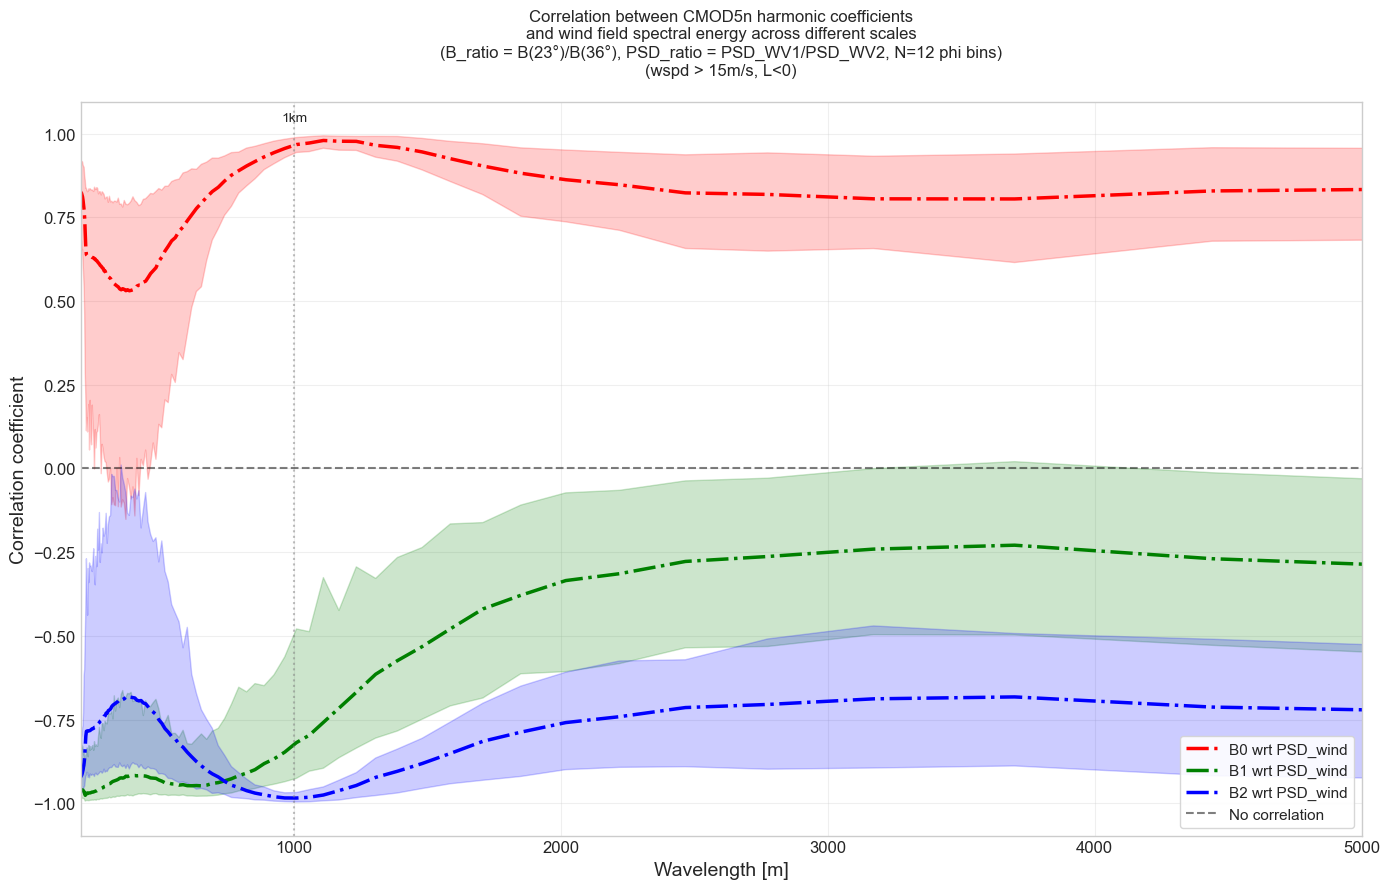

In [196]:
plot_b_coeff_correlations(
    wavelengths,
    b0_corr, b0_lo, b0_hi,
    b1_corr, b1_lo, b1_hi,
    b2_corr, b2_lo, b2_hi,
    use_semilogx=False
)

In [19]:
era5_wspd_mapping1 = df1r.set_index('renamed_filename')['era5_wspd']
era5_wspd_mapping2 = df2r.set_index('renamed_filename')['era5_wspd']

df1w['era5_wspd'] = df1w['renamed_filename'].map(era5_wspd_mapping1)
df2w['era5_wspd'] = df2w['renamed_filename'].map(era5_wspd_mapping2)

=== WIND FIELD BIAS ANALYSIS BY PHI_BINS ===

Bias = wind_field_median - era5_wspd
Positive bias = overestimation, Negative bias = underestimation

              era5_wspd_mean  era5_wspd_std  era5_wspd_count  \
phi_bins                                                       
[-10, -8)             16.765          1.510              415   
[-100, -98)           16.759          1.550               49   
[-102, -100)          16.532          1.552               38   
[-104, -102)          17.032          1.631               49   
[-106, -104)          16.649          1.764               53   
...                      ...            ...              ...   
[90, 92)              16.755          1.839              114   
[92, 94)              16.681          1.383              136   
[94, 96)              16.713          1.608              127   
[96, 98)              16.554          1.277              134   
[98, 100)             16.625          1.515              154   

              wind_

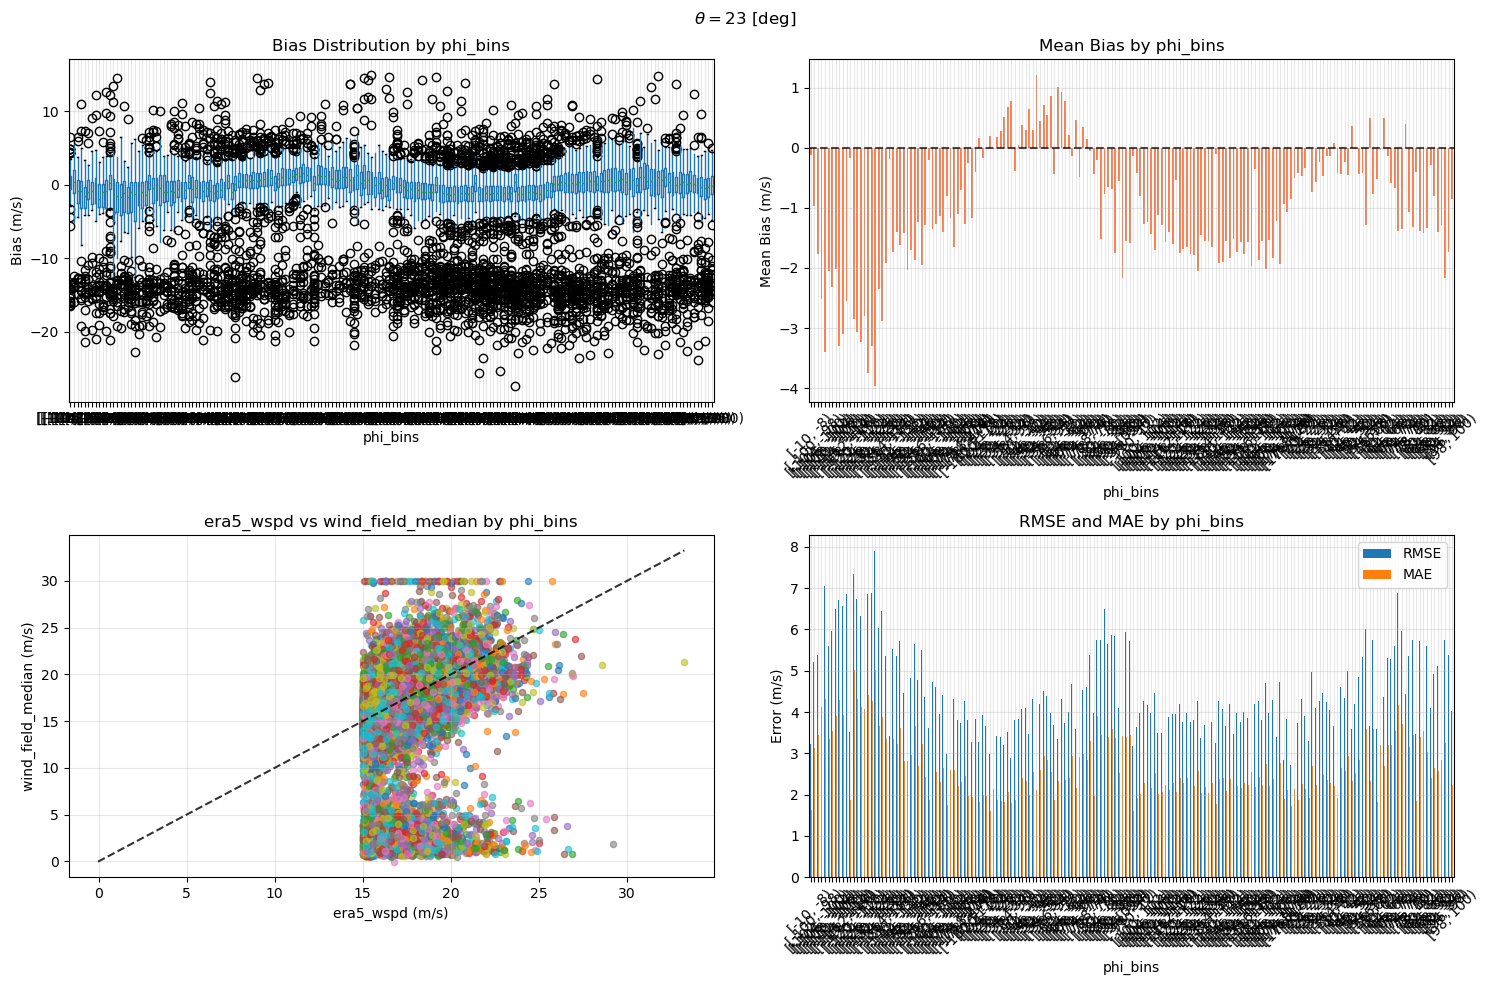


=== INTERPRETATION GUIDE ===
• Mean Bias: Average difference (retrieved - true)
  - Positive = systematic overestimation
  - Negative = systematic underestimation
• MAE: Mean Absolute Error (average magnitude of errors)
• RMSE: Root Mean Square Error (penalizes larger errors more)
• Correlation: Linear relationship strength (-1 to 1)
• Relative Bias %: Bias as percentage of true mean value
=== WIND FIELD BIAS ANALYSIS BY PHI_BINS ===

Bias = wind_field_median - era5_wspd
Positive bias = overestimation, Negative bias = underestimation

              era5_wspd_mean  era5_wspd_std  era5_wspd_count  \
phi_bins                                                       
[-10, -8)             16.896          1.666              405   
[-100, -98)           16.867          1.526               56   
[-102, -100)          16.587          1.180               47   
[-104, -102)          16.647          1.671               48   
[-106, -104)          16.786          1.763               47   
...       

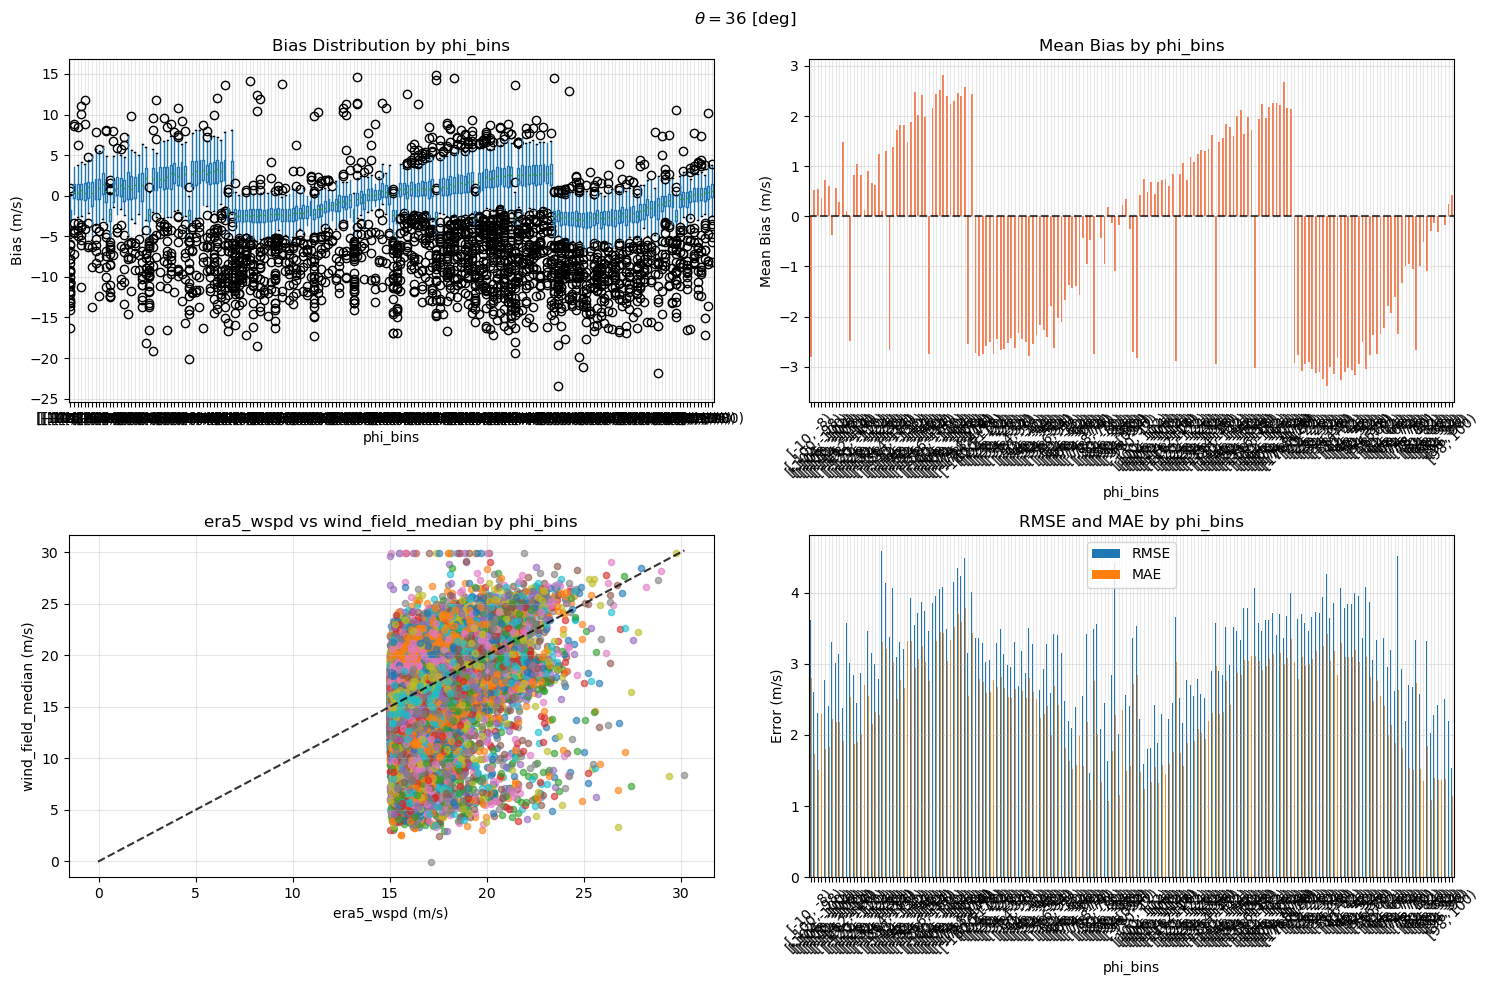


=== INTERPRETATION GUIDE ===
• Mean Bias: Average difference (retrieved - true)
  - Positive = systematic overestimation
  - Negative = systematic underestimation
• MAE: Mean Absolute Error (average magnitude of errors)
• RMSE: Root Mean Square Error (penalizes larger errors more)
• Correlation: Linear relationship strength (-1 to 1)
• Relative Bias %: Bias as percentage of true mean value


In [20]:
bias_results = analyze_wind_bias(df1w, "$\\theta = 23$ [deg]")
bias_results = analyze_wind_bias(df2w, "$\\theta = 36$ [deg]")

In [21]:
k_thresh = 1/2000
sub2_mask = k_values > k_thresh

df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(x[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(x[sub2_mask]))

In [22]:
df1w_median_sub2energy = np.median(df1w['sub2_energy'])
df2w_median_sub2energy = np.median(df2w['sub2_energy'])

In [23]:
df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

In [24]:
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

In [25]:
mean_error_high = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()

In [26]:
ub2_mask = k_values > k_thresh  # mask for high-frequency bins

# Apply to both datasets
df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))

# Step 2: Binning by variability
df1w_median_sub2energy = df1w['sub2_energy'].median()
df2w_median_sub2energy = df2w['sub2_energy'].median()

df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

# Step 3: Compute error
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

# Step 4: Compute stats (optional)
mean_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].std()

mean_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].std()

In [27]:
print("=======PSDs filtered at < 2 km=======")
print(f"WV1 High Variability Mean Error: {mean_error_high_wv1:.2f}, Std: {std_error_high_wv1:.2f}")
print(f"WV1 Low Variability Mean Error: {mean_error_low_wv1:.2f}, Std: {std_error_low_wv1:.2f}")
print(f"WV2 High Variability Mean Error: {mean_error_high_wv2:.2f}, Std: {std_error_high_wv2:.2f}")
print(f"WV2 Low Variability Mean Error: {mean_error_low_wv2:.2f}, Std: {std_error_low_wv2:.2f}")

=======PSDs filtered at < 2 km=======
WV1 High Variability Mean Error: 0.21, Std: 2.14
WV1 Low Variability Mean Error: -2.01, Std: 5.10
WV2 High Variability Mean Error: 0.40, Std: 3.60
WV2 Low Variability Mean Error: -1.55, Std: 2.48


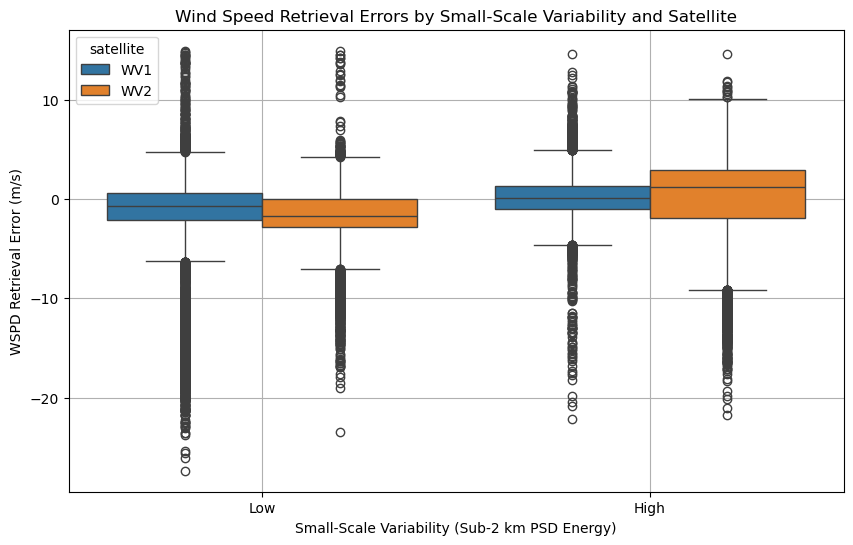

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

df1w['satellite'] = 'WV1'
df2w['satellite'] = 'WV2'

df_all = pd.concat([df1w, df2w])

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x='variability_label', y='wspd_error', hue='satellite')
plt.title('Wind Speed Retrieval Errors by Small-Scale Variability and Satellite')
plt.ylabel('WSPD Retrieval Error (m/s)')
plt.xlabel('Small-Scale Variability (Sub-2 km PSD Energy)')
plt.grid(True)
plt.show()


=======PSDs filtered at > 2 km=======
WV1 High Variability Mean Error: 0.51, Std: 2.11
WV1 Low Variability Mean Error: -2.30, Std: 4.97
WV2 High Variability Mean Error: 0.78, Std: 2.67
WV2 Low Variability Mean Error: -1.93, Std: 3.20


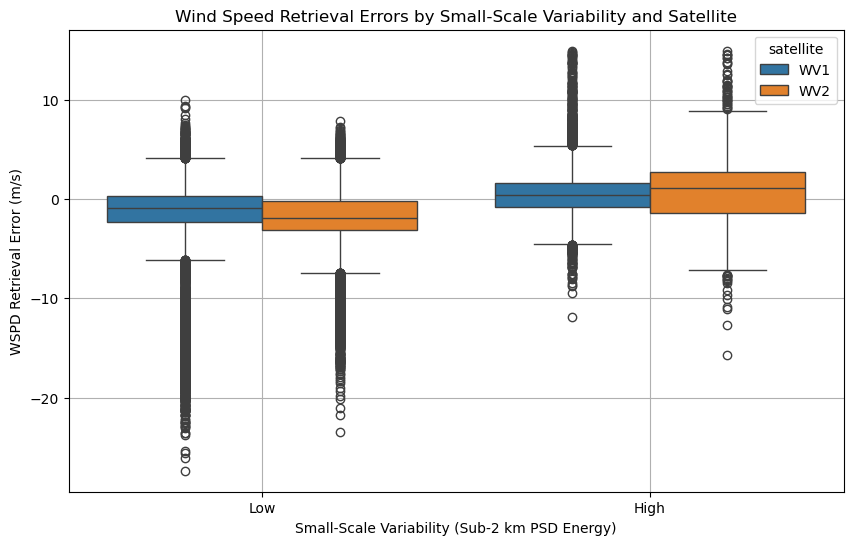

In [29]:
sub2_mask = k_values < k_thresh  # mask for high-frequency bins

# Apply to both datasets
df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))

# Step 2: Binning by variability
df1w_median_sub2energy = df1w['sub2_energy'].median()
df2w_median_sub2energy = df2w['sub2_energy'].median()

df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

# Step 3: Compute error
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

# Step 4: Compute stats (optional)
mean_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].std()

mean_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].std()

print("=======PSDs filtered at > 2 km=======")
print(f"WV1 High Variability Mean Error: {mean_error_high_wv1:.2f}, Std: {std_error_high_wv1:.2f}")
print(f"WV1 Low Variability Mean Error: {mean_error_low_wv1:.2f}, Std: {std_error_low_wv1:.2f}")
print(f"WV2 High Variability Mean Error: {mean_error_high_wv2:.2f}, Std: {std_error_high_wv2:.2f}")
print(f"WV2 Low Variability Mean Error: {mean_error_low_wv2:.2f}, Std: {std_error_low_wv2:.2f}")

df1w['satellite'] = 'WV1'
df2w['satellite'] = 'WV2'

df_all = pd.concat([df1w, df2w])

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x='variability_label', y='wspd_error', hue='satellite')
plt.title('Wind Speed Retrieval Errors by Small-Scale Variability and Satellite')
plt.ylabel('WSPD Retrieval Error (m/s)')
plt.xlabel('Small-Scale Variability (Sub-2 km PSD Energy)')
plt.grid(True)
plt.show()


=======PSDs filtered nowhere =======
WV1 High Variability Mean Error: 0.51, Std: 2.11
WV1 Low Variability Mean Error: -2.30, Std: 4.97
WV2 High Variability Mean Error: 0.78, Std: 2.67
WV2 Low Variability Mean Error: -1.93, Std: 3.20


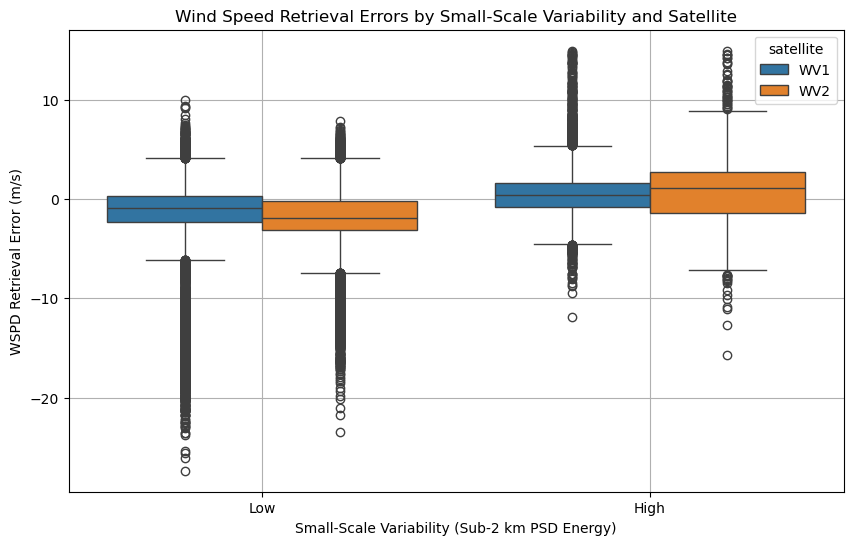

In [30]:
sub2_mask = None  # mask for high-frequency bins

# Apply to both datasets
df1w['sub2_energy'] = df1w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))
df2w['sub2_energy'] = df2w['radial_wind_psd_padded'].apply(lambda x: np.sum(np.array(x)[sub2_mask]))

# Step 2: Binning by variability
df1w_median_sub2energy = df1w['sub2_energy'].median()
df2w_median_sub2energy = df2w['sub2_energy'].median()

df1w['variability_label'] = df1w['sub2_energy'].apply(lambda x: 'High' if x > df1w_median_sub2energy else 'Low')
df2w['variability_label'] = df2w['sub2_energy'].apply(lambda x: 'High' if x > df2w_median_sub2energy else 'Low')

# Step 3: Compute error
df1w['wspd_error'] = df1w['wind_field_median'] - df1w['era5_wspd']
df2w['wspd_error'] = df2w['wind_field_median'] - df2w['era5_wspd']

# Step 4: Compute stats (optional)
mean_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv1 = df1w[df1w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv1 = df1w[df1w['variability_label'] == 'Low']['wspd_error'].std()

mean_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].mean()
mean_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].mean()
std_error_high_wv2 = df2w[df2w['variability_label'] == 'High']['wspd_error'].std()
std_error_low_wv2 = df2w[df2w['variability_label'] == 'Low']['wspd_error'].std()

print("=======PSDs filtered nowhere =======")
print(f"WV1 High Variability Mean Error: {mean_error_high_wv1:.2f}, Std: {std_error_high_wv1:.2f}")
print(f"WV1 Low Variability Mean Error: {mean_error_low_wv1:.2f}, Std: {std_error_low_wv1:.2f}")
print(f"WV2 High Variability Mean Error: {mean_error_high_wv2:.2f}, Std: {std_error_high_wv2:.2f}")
print(f"WV2 Low Variability Mean Error: {mean_error_low_wv2:.2f}, Std: {std_error_low_wv2:.2f}")

df1w['satellite'] = 'WV1'
df2w['satellite'] = 'WV2'

df_all = pd.concat([df1w, df2w])

plt.figure(figsize=(10,6))
sns.boxplot(data=df_all, x='variability_label', y='wspd_error', hue='satellite')
plt.title('Wind Speed Retrieval Errors by Small-Scale Variability and Satellite')
plt.ylabel('WSPD Retrieval Error (m/s)')
plt.xlabel('Small-Scale Variability (Sub-2 km PSD Energy)')
plt.grid(True)
plt.show()


In [31]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=1)
# plot_directional_differences(d, k_valuesa, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)

Performing block bootstrap with 1038 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 811.43it/s]


Performing block bootstrap with 1129 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 658.38it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4113.30it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4598.72it/s]


Performing block bootstrap with 253 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5253.18it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 5794.88it/s]


Performing block bootstrap with 236 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6076.39it/s]

Performing block bootstrap with 259 samples, block size 16, and 1000 replicates



100%|██████████| 1000/1000 [00:00<00:00, 6492.46it/s]


Performing block bootstrap with 406 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4899.84it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4909.78it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 682.39it/s]


Performing block bootstrap with 1447 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 580.12it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 399.71it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 376.22it/s]


Performing block bootstrap with 1337 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 721.91it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 710.94it/s]


Performing block bootstrap with 540 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3514.23it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3641.03it/s]


Performing block bootstrap with 640 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3480.48it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3788.71it/s]


Performing block bootstrap with 1844 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 531.51it/s]


Performing block bootstrap with 1778 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 539.43it/s]


Performing block bootstrap with 2211 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 448.25it/s]


Performing block bootstrap with 2166 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 454.00it/s]


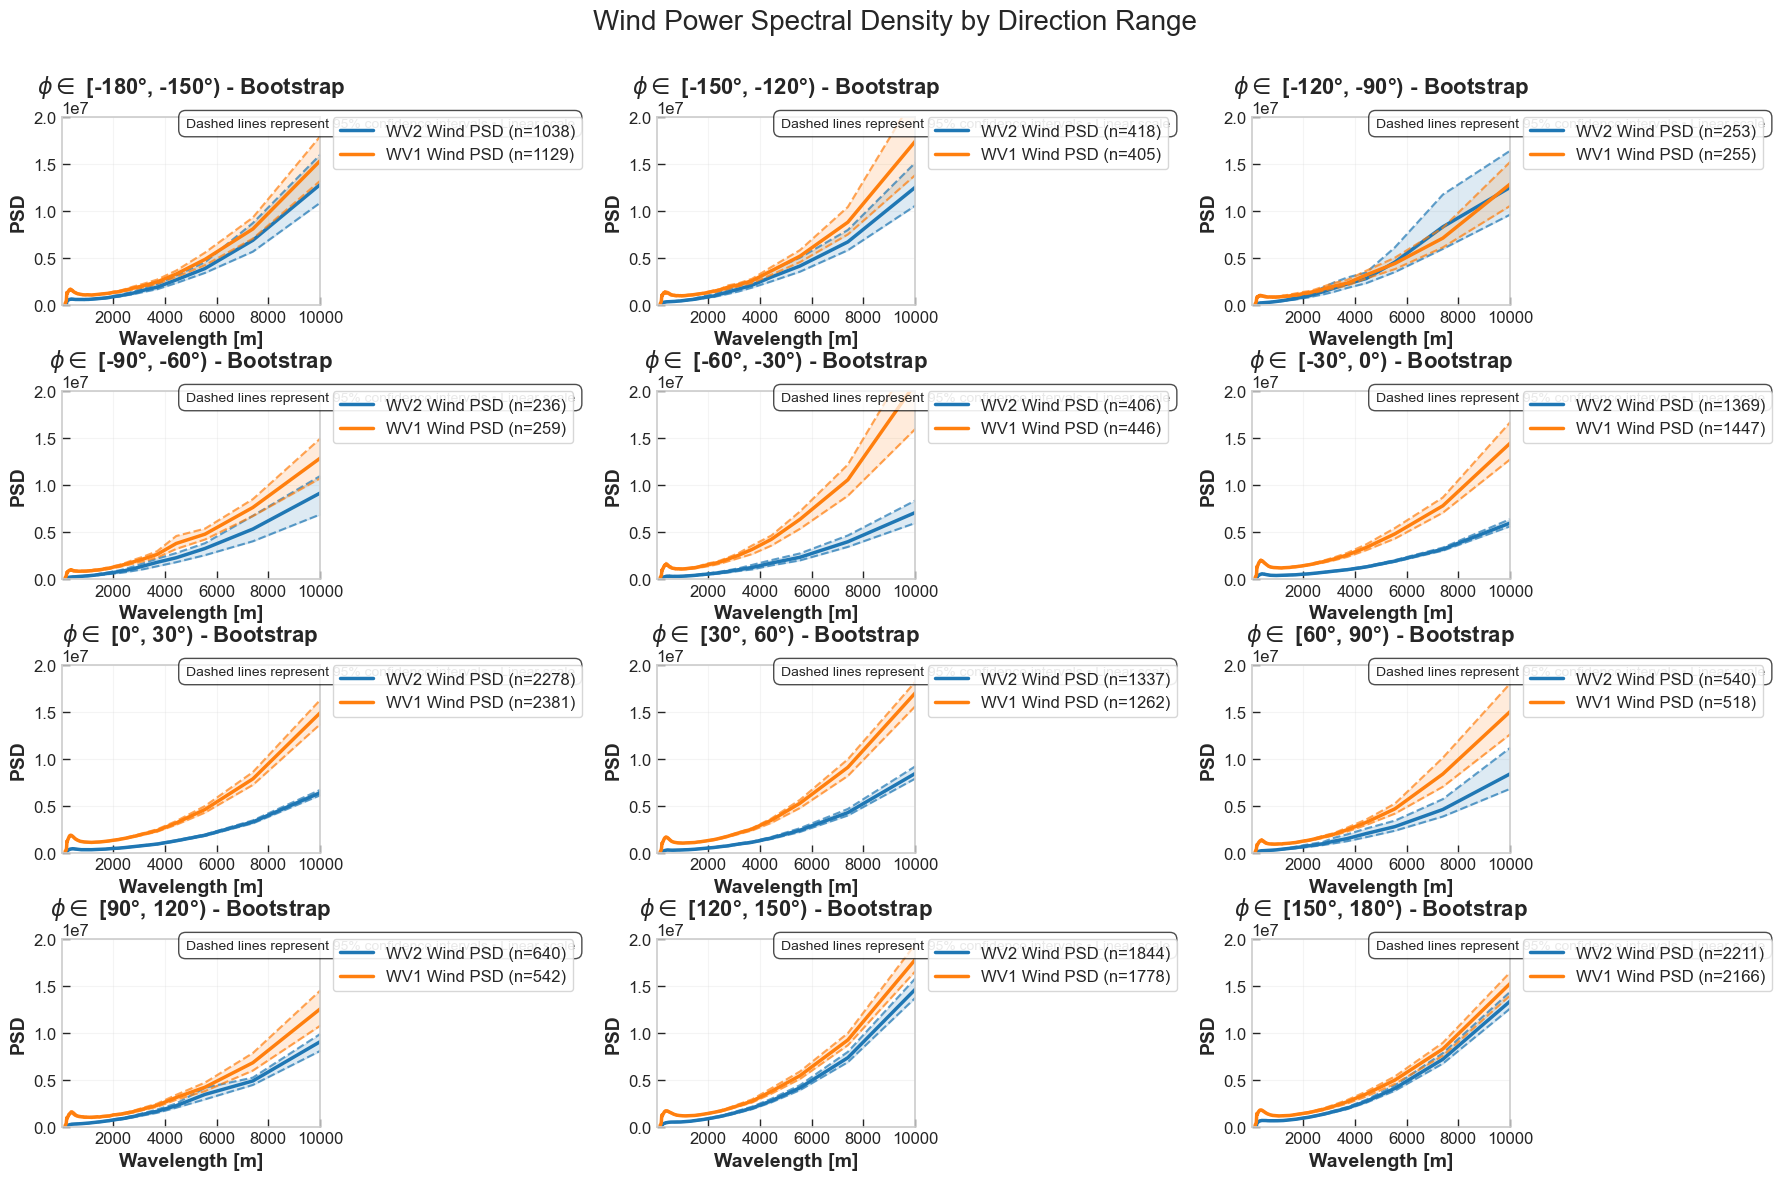

In [153]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, df1w_filtered],
                              ["WV2 Wind PSD", "WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                              x_range=(0.0001, 0.15), y_range=(0, 0.2e8),
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax)  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

Performing block bootstrap with 1132 samples, block size 33, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 773.13it/s]


Performing block bootstrap with 405 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4247.55it/s]


Performing block bootstrap with 255 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6236.55it/s]


Performing block bootstrap with 259 samples, block size 16, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 6807.95it/s]


Performing block bootstrap with 446 samples, block size 21, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4124.42it/s]


Performing block bootstrap with 1448 samples, block size 38, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 573.73it/s]


Performing block bootstrap with 2381 samples, block size 48, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 357.43it/s]


Performing block bootstrap with 1262 samples, block size 35, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 647.97it/s]


Performing block bootstrap with 518 samples, block size 22, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3712.68it/s]


Performing block bootstrap with 542 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 3515.84it/s]


Performing block bootstrap with 1781 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 466.60it/s]


Performing block bootstrap with 2171 samples, block size 46, and 1000 replicates


100%|██████████| 1000/1000 [00:02<00:00, 372.09it/s]


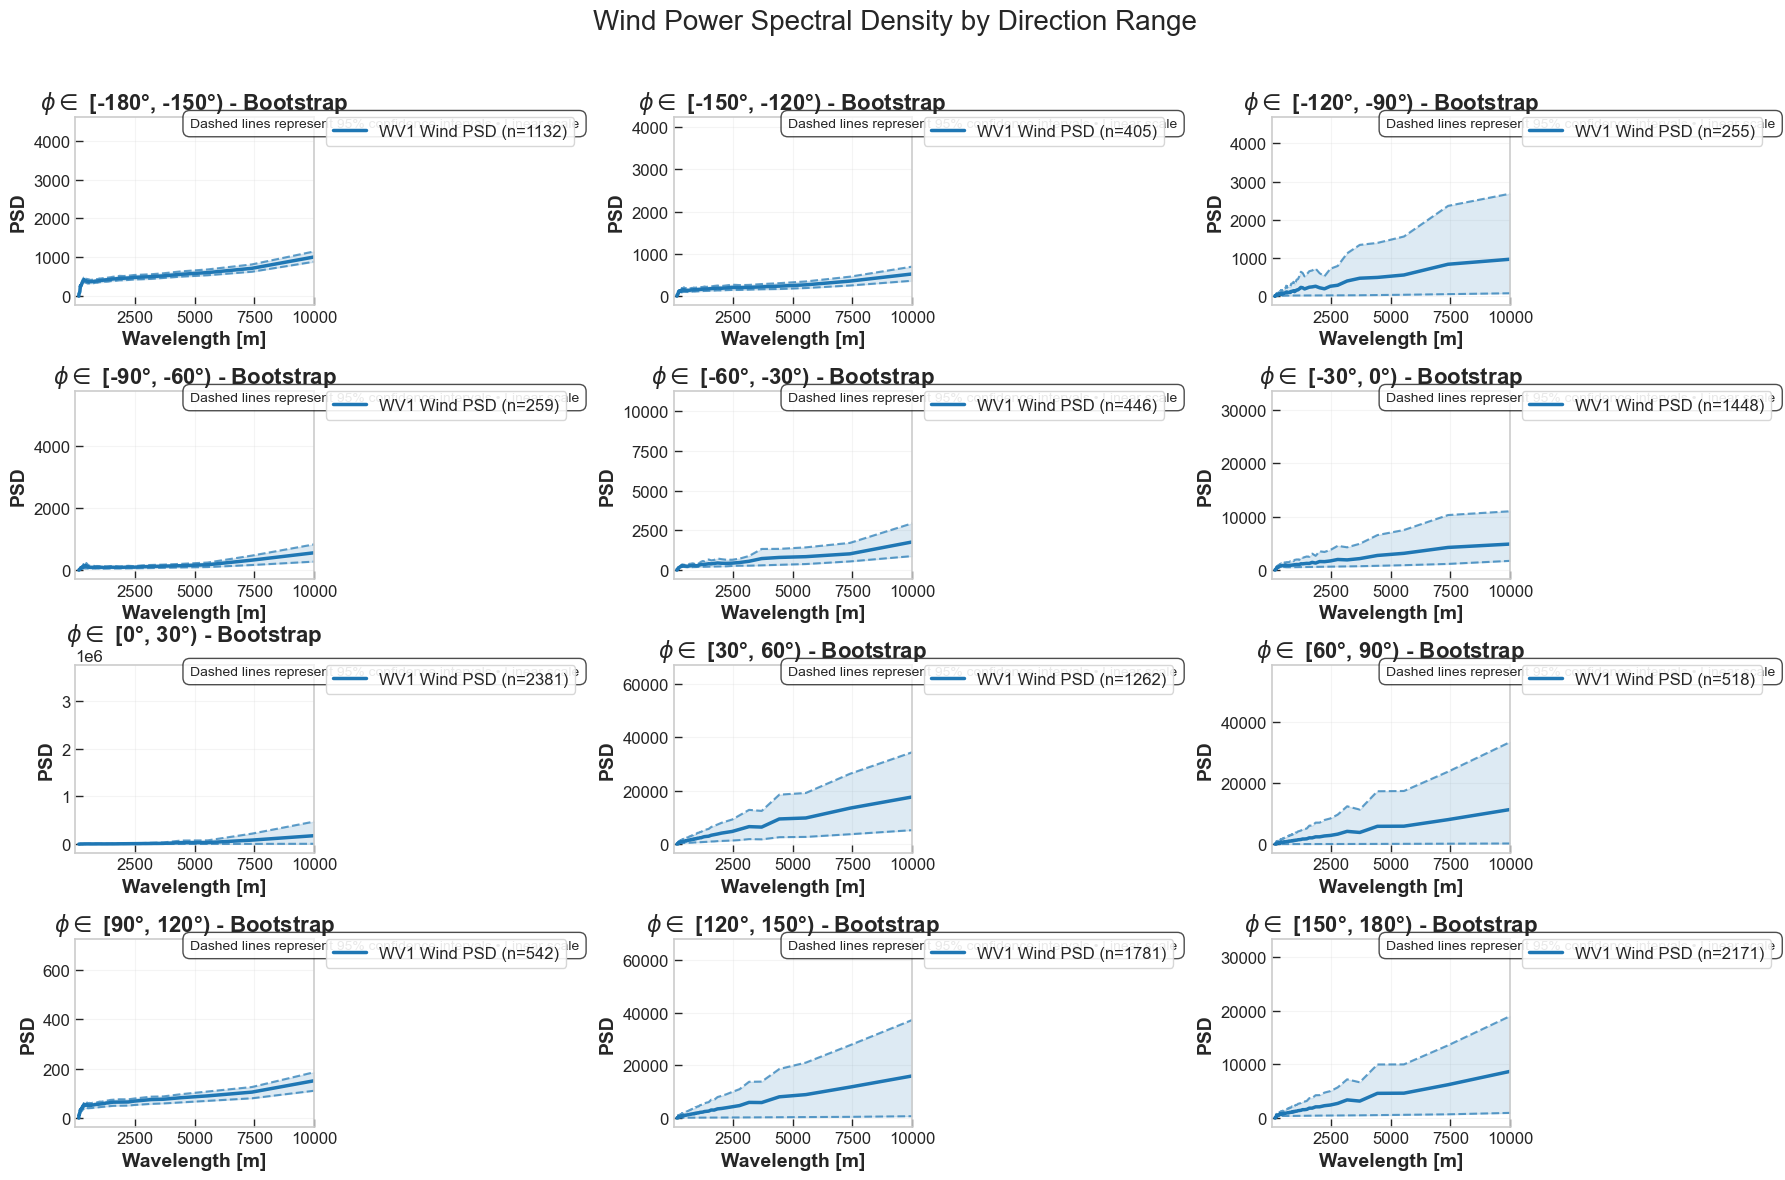

In [58]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    # df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    # df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    # df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df1w_filtered],
                              ["WV1 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                            #   x_range=(0.0001, 0.15), y_range=(0, 0.2e8),
                            x_range=(0.0001, 0.15), #y_range=(0, 0.2e4), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax, column_name='radial_residual_psd_padded')  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

Performing block bootstrap with 1038 samples, block size 32, and 1000 replicates


100%|██████████| 1000/1000 [00:01<00:00, 823.36it/s]


Performing block bootstrap with 418 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4179.06it/s]


Performing block bootstrap with 253 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7143.96it/s]


Performing block bootstrap with 236 samples, block size 15, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 7175.80it/s]


Performing block bootstrap with 406 samples, block size 20, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 4703.54it/s]


Performing block bootstrap with 1369 samples, block size 37, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 174.83it/s]


Performing block bootstrap with 2278 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:08<00:00, 122.21it/s]


Performing block bootstrap with 1337 samples, block size 36, and 1000 replicates


100%|██████████| 1000/1000 [00:05<00:00, 175.76it/s]


Performing block bootstrap with 540 samples, block size 23, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1304.31it/s]


Performing block bootstrap with 640 samples, block size 25, and 1000 replicates


100%|██████████| 1000/1000 [00:00<00:00, 1049.22it/s]


Performing block bootstrap with 1844 samples, block size 42, and 1000 replicates


100%|██████████| 1000/1000 [00:08<00:00, 123.09it/s]


Performing block bootstrap with 2211 samples, block size 47, and 1000 replicates


100%|██████████| 1000/1000 [00:07<00:00, 139.48it/s]


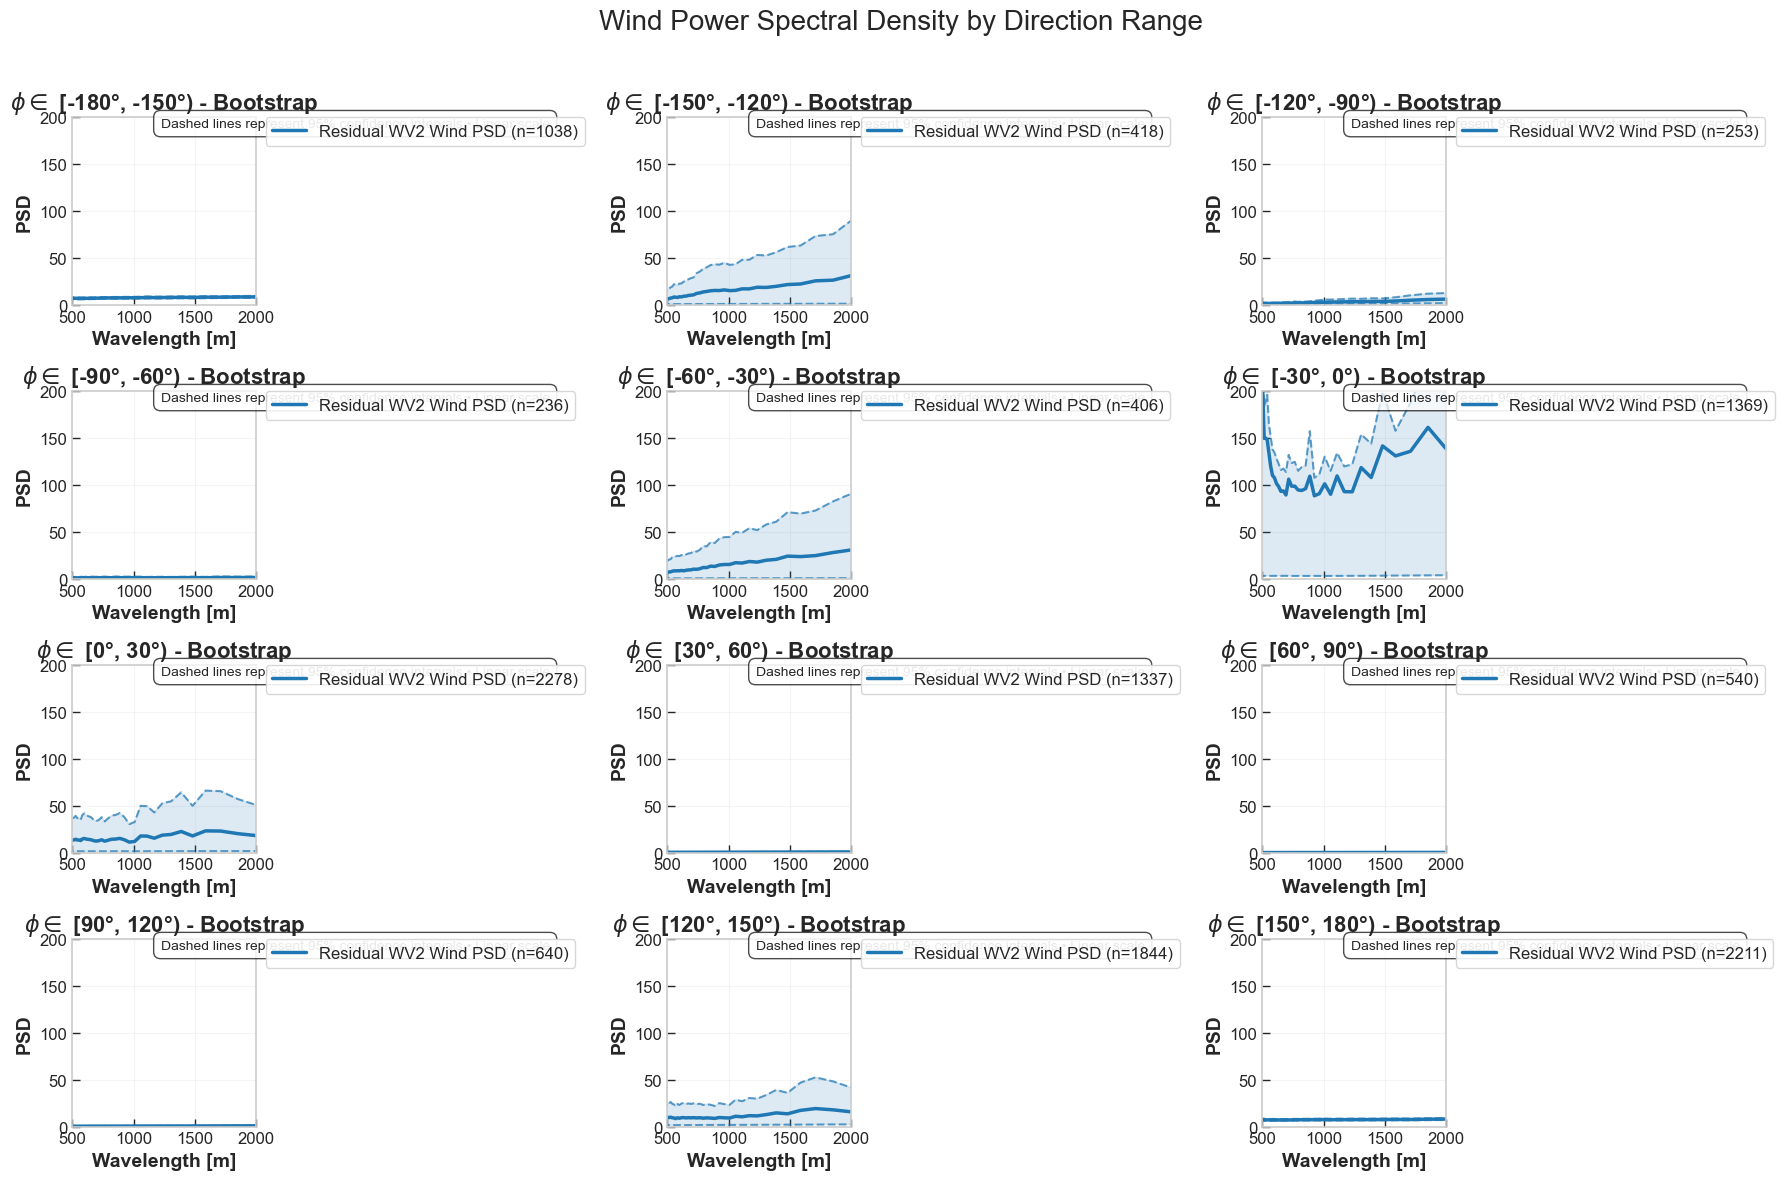

In [192]:
intervals = np.arange(-180, 181, 30)

# Create the figure and axes
fig, axes = plt.subplots(4, 3, figsize=(18, 12))

# Flatten the 2D array of axes
flat_axes = axes.flatten()

for i in range(len(intervals)-1):
    a = intervals[i]
    b = intervals[i+1]
    
    # Skip if we've run out of axes
    if i >= len(flat_axes):
        print(f"Warning: Not enough axes for interval {a} to {b}")
        continue
        
    # Get the current axis
    current_ax = flat_axes[i]
    
    # Construct filtered DataFrames for the current interval
    df1_filtered, df1r_filtered, df1w_filtered, df2_filtered, df2r_filtered, df2w_filtered = construct_df(a, b, df1, df1r, df1w, df2, df2r, df2w)
    # df1_filtered = filter_similar_atmospheric_conditions(df1_filtered, L_range=(-1e6, -1000))
    df2_filtered = filter_similar_atmospheric_conditions(df2_filtered, L_range=(-1e6, -1000))

    # df1r_filtered = df1r_filtered[df1r_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2r_filtered = df2r_filtered[df2r_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # df1w_filtered = df1w_filtered[df1w_filtered["renamed_filename"].isin(df1_filtered["renamed_filename"])]
    df2w_filtered = df2w_filtered[df2w_filtered["renamed_filename"].isin(df2_filtered["renamed_filename"])]

    # Plot on the current axis
    _, _ = plot_avg_spectral_density(k_values, [df2w_filtered, ],
                              ["Residual WV2 Wind PSD"],
                              f"$\\phi \\in$ [{a}°, {b}°)", 
                            #   x_range=(0.0001, 0.15), y_range=(0, 0.2e8),
                            x_range=(1/2000, 1/500), y_range=(0, 200), 
                              use_log_scale=False, wavelength=True, bootstrap=True,
                              ax=current_ax, column_name='radial_residual_psd_padded')  

# Hide any unused axes
for j in range(i+1, len(flat_axes)):
    flat_axes[j].set_visible(False)

# Add a common title for the entire figure
fig.suptitle('Wind Power Spectral Density by Direction Range', fontsize=20, y=0.98)

# Adjust spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.96])  # The rect parameter reserves space for the suptitle

# Show the figure
plt.show()

In [ ]:
# df1_m180_m150, df1r_m180_m150, df1w_m180_m150, df2_m180_m150, df2r_m180_m150, df2w_m180_m150 = construct_df(-180, -150, df1, df1r, df1w, df2, df2r, df2w)
# df1_m150_m120, df1r_m150_m120, df1w_m150_m120, df2_m150_m120, df2r_m150_m120, df2w_m150_m120 = construct_df(-150, -120, df1, df1r, df1w, df2, df2r, df2w)
# df1_m120_m90, df1r_m120_m90, df1w_m120_m90, df2_m120_m90, df2r_m120_m90, df2w_m120_m90 = construct_df(-120, -90, df1, df1r, df1w, df2, df2r, df2w)
# df1_m90_m60, df1r_m90_m60, df1w_m90_m60, df2_m90_m60, df2r_m90_m60, df2w_m90_m60 = construct_df(-90, -60, df1, df1r, df1w, df2, df2r, df2w)
# df1_m60_m30, df1r_m60_m30, df1w_m60_m30, df2_m60_m30, df2r_m60_m30, df2w_m60_m30 = construct_df(-60, -30, df1, df1r, df1w, df2, df2r, df2w)
# df1_m30_0, df1r_m30_0, df1w_m30_0, df2_m30_0, df2r_m30_0, df2w_m30_0 = construct_df(-30, 0, df1, df1r, df1w, df2, df2r, df2w)
# df1_0_30, df1r_0_30, df1w_0_30, df2_0_30, df2r_0_30, df2w_0_30 = construct_df(0, 30, df1, df1r, df1w, df2, df2r, df2w)
# df1_30_60, df1r_30_60, df1w_30_60, df2_30_60, df2r_30_60, df2w_30_60 = construct_df(30, 60, df1, df1r, df1w, df2, df2r, df2w)
# df1_60_90, df1r_60_90, df1w_60_90, df2_60_90, df2r_60_90, df2w_60_90 = construct_df(60, 90, df1, df1r, df1w, df2, df2r, df2w)
# df1_90_120, df1r_90_120, df1w_90_120, df2_90_120, df2r_90_120, df2w_90_120 = construct_df(90, 120, df1, df1r, df1w, df2, df2r, df2w)
# df1_120_150, df1r_120_150, df1w_120_150, df2_120_150, df2r_120_150, df2w_120_150 = construct_df(120, 150, df1, df1r, df1w, df2, df2r, df2w)
# df1_150_180, df1r_150_180, df1w_150_180, df2_150_180, df2r_150_180, df2w_150_180 = construct_df(150, 180, df1, df1r, df1w, df2, df2r, df2w)

In [ ]:
# df1_reconstructed = pd.concat([df1_m180_m150, df1_m150_m120, df1_m120_m90, df1_m90_m60, df1_m60_m30, df1_m30_0,
#                                df1_0_30, df1_30_60, df1_60_90, df1_90_120, df1_120_150, df1_150_180], ignore_index=True)

# df2_reconstructed = pd.concat([df2_m180_m150, df2_m150_m120, df2_m120_m90, df2_m90_m60, df2_m60_m30, df2_m30_0,
#                                  df2_0_30, df2_30_60, df2_60_90, df2_90_120, df2_120_150, df2_150_180], ignore_index=True)

In [ ]:
# filtered_df1 = filter_similar_atmospheric_conditions(df1_reconstructed, L_range=(-1e6, -1000))
# filtered_df2 = filter_similar_atmospheric_conditions(df2_reconstructed, L_range=(-1e6, -1000))
# filtered_df1r = df1r[df1r["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2r = df2r[df2r["renamed_filename"].isin(filtered_df2["renamed_filename"])]
# filtered_df1w = df1w[df1w["renamed_filename"].isin(filtered_df1["renamed_filename"])]
# filtered_df2w = df2w[df2w["renamed_filename"].isin(filtered_df2["renamed_filename"])]

# d = compute_directional_differences(filtered_df1, filtered_df2,
#                                     filtered_df1r, filtered_df2r, 
#                                     filtered_df1w, filtered_df2w, 
#                                     k_values=k_values, phi_res=30)

# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                 max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                 title=f"Directional Differences - Filtered - L_range {(-1e6, -1000)}")

In [ ]:
# # wspd_range = (18, 19)
# L_ranges = [(-1e6, -1000), (-1000, -500), (-500, 0)]
# ds = []
# for L_range in L_ranges:
#     filtered_df1 = filter_similar_atmospheric_conditions(df1, L_range=L_range)
#     filtered_df2 = filter_similar_atmospheric_conditions(df2, L_range=L_range)

#     filtered_df1r = df1r[df1r['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2r = df2r[df2r['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1w = df1w[df1w['renamed_filename'].isin(filtered_df1['renamed_filename'])]
#     filtered_df2w = df2w[df2w['renamed_filename'].isin(filtered_df2['renamed_filename'])]

#     filtered_df1_rg_uw = filter_similar_atmospheric_conditions(df1_rg_uw, L_range=L_range)
#     filtered_df2_rg_uw = filter_similar_atmospheric_conditions(df2_rg_uw, L_range=L_range)
#     filtered_df1r_rg_uw = df1r_rg_uw[df1r_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2r_rg_uw = df2r_rg_uw[df2r_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]
#     filtered_df1w_rg_uw = df1w_rg_uw[df1w_rg_uw['renamed_filename'].isin(filtered_df1_rg_uw['renamed_filename'])]
#     filtered_df2w_rg_uw = df2w_rg_uw[df2w_rg_uw['renamed_filename'].isin(filtered_df2_rg_uw['renamed_filename'])]

#     filtered_df1_rg_dw = filter_similar_atmospheric_conditions(df1_rg_dw, L_range=L_range)
#     filtered_df2_rg_dw = filter_similar_atmospheric_conditions(df2_rg_dw, L_range=L_range)
#     filtered_df1r_rg_dw = df1r_rg_dw[df1r_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2r_rg_dw = df2r_rg_dw[df2r_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]
#     filtered_df1w_rg_dw = df1w_rg_dw[df1w_rg_dw['renamed_filename'].isin(filtered_df1_rg_dw['renamed_filename'])]
#     filtered_df2w_rg_dw = df2w_rg_dw[df2w_rg_dw['renamed_filename'].isin(filtered_df2_rg_dw['renamed_filename'])]

#     filtered_df1_az_lr = filter_similar_atmospheric_conditions(df1_az_lr, L_range=L_range)
#     filtered_df2_az_lr = filter_similar_atmospheric_conditions(df2_az_lr, L_range=L_range)
#     filtered_df1r_az_lr = df1r_az_lr[df1r_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2r_az_lr = df2r_az_lr[df2r_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]
#     filtered_df1w_az_lr = df1w_az_lr[df1w_az_lr['renamed_filename'].isin(filtered_df1_az_lr['renamed_filename'])]
#     filtered_df2w_az_lr = df2w_az_lr[df2w_az_lr['renamed_filename'].isin(filtered_df2_az_lr['renamed_filename'])]

#     filtered_df1_az_rl = filter_similar_atmospheric_conditions(df1_az_rl, L_range=L_range)
#     filtered_df2_az_rl = filter_similar_atmospheric_conditions(df2_az_rl, L_range=L_range)
#     filtered_df1r_az_rl = df1r_az_rl[df1r_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2r_az_rl = df2r_az_rl[df2r_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]
#     filtered_df1w_az_rl = df1w_az_rl[df1w_az_rl['renamed_filename'].isin(filtered_df1_az_rl['renamed_filename'])]
#     filtered_df2w_az_rl = df2w_az_rl[df2w_az_rl['renamed_filename'].isin(filtered_df2_az_rl['renamed_filename'])]

#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_uw, filtered_df1w_rg_uw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg uw", 
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7), 
#                             use_log_scale=False, wavelength=True);

    
#     plot_avg_spectral_density(k_values, [filtered_df2w_rg_dw, filtered_df1w_rg_dw], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - rg dw",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_lr, filtered_df1w_az_lr], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az lr",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);
    
#     plot_avg_spectral_density(k_values, [filtered_df2w_az_rl, filtered_df1w_az_rl], ["WV2 Wind PSD", "WV1 Wind PSD"],
#                             f"Average Wind PSD - Filtered - L_range {L_range} - az rl",
#                             x_range=(0.005, 0.15), y_range=(1, 0.2e7),
#                             use_log_scale=False, wavelength=True);

#     d = compute_directional_differences(filtered_df1, filtered_df2,
#                                         filtered_df1r, filtered_df2r, 
#                                         filtered_df1w, filtered_df2w, 
#                                         k_values=k_values, phi_res=5)
    
#     plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r',
#                                  max_wavelength=120, vmin=-1e6, vmax=1e6,
#                                  title=f"Directional Differences - Filtered - L_range {L_range}")

In [ ]:
# d = compute_directional_differences(df1, df2, df1r, df2r, df1w, df2w, k_values, phi_res=5)

In [ ]:
# plot_directional_differences(d, k_values, plot_type='wavelength', cmap='RdBu_r', 
#                              max_wavelength=100, vmin=-1e6, vmax=1e6)